In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

C:\Users\madst\AppData\Local\Temp\ipykernel_23656\2736219923.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp['Time'] = pd.to_datetime(gdp['Time'])


Data types in 'indu' dataframe:
Time     datetime64[ns]
Value             int64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


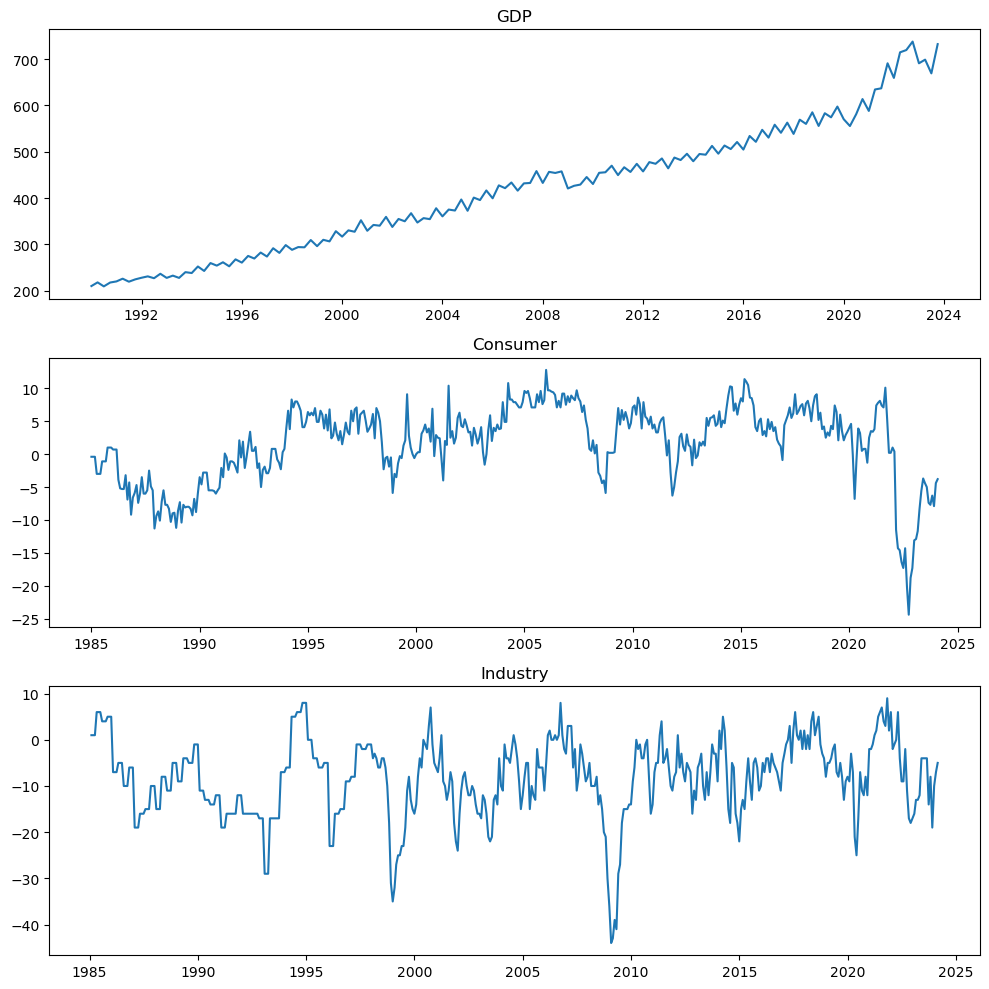

C:\Users\madst\AppData\Local\Temp\ipykernel_23656\3324521213.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  indu_quarterly = indu.resample('Q', on='Time').mean()
C:\Users\madst\AppData\Local\Temp\ipykernel_23656\3324521213.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  cons_quarterly = cons.resample('Q', on='Time').mean()


Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


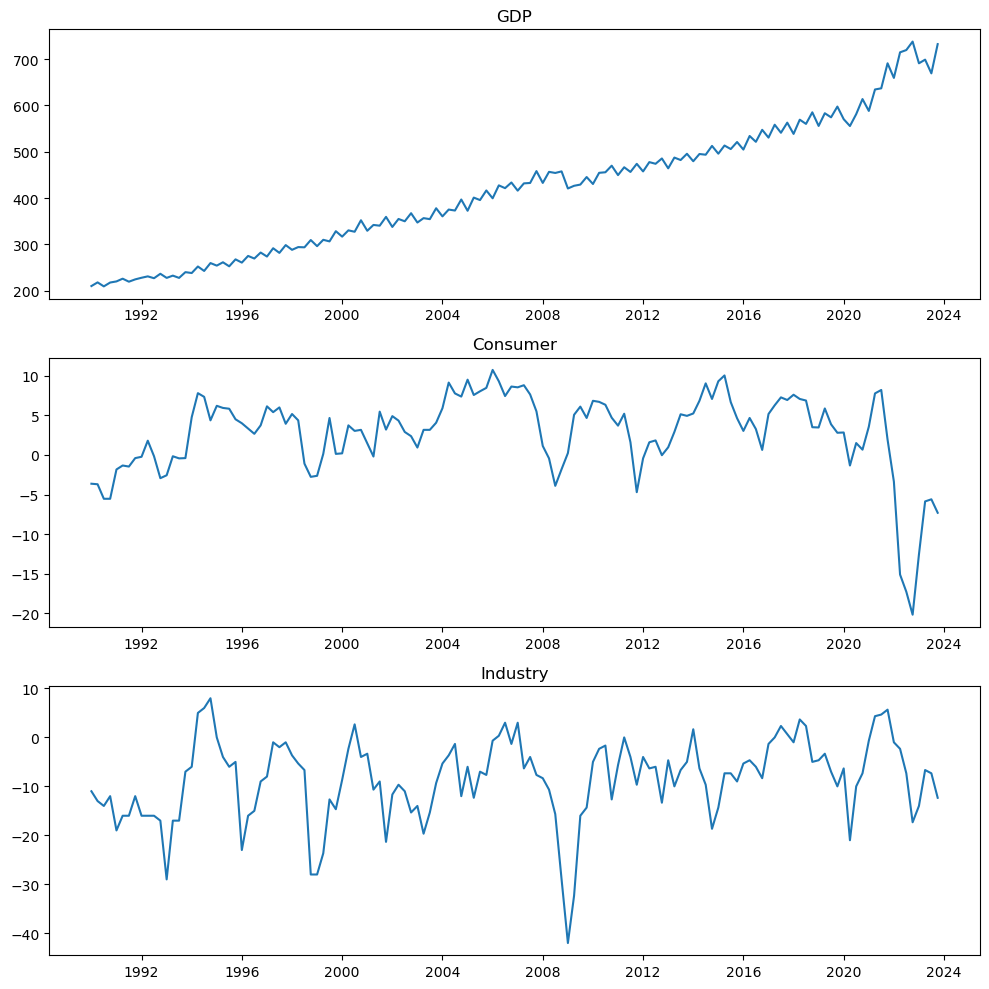

In [1]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

In [8]:
#Split the data into training and testing sets
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2021-01-01')]
indu_test = indu[(indu['Time'] >= '2021-01-01')]

cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2021-01-01')]
cons_test = cons[(cons['Time'] >= '2021-01-01')]

gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2021-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2021-01-01')]

#Since gdp is not stationary, we will take the first difference
gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)

#Combine the explanatory data into one dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)

exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)

#Extract the target variable
endog_train = gdp_train['Value_diff']
endog_test = gdp_test['Value']

# Instantiating the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Fitting the model
xgb_reg.fit(exog_train, endog_train)

# Forecasting the GDP
y_pred = xgb_reg.predict(exog_test)

#Reversing the first difference
y_pred_norm = np.cumsum(y_pred) + gdp_test['Value'].iloc[0]

# Calculating the RMSE
rmse_value = mean_squared_error(endog_test, y_pred_norm, squared=False)

print("The RMSE of the model is: ", rmse_value)

The RMSE of the model is:  69.90887275306662


C:\Users\madst\AppData\Local\Temp\ipykernel_10264\3356276076.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_train['Value_diff'] = gdp_train['Value'].diff().fillna(0)


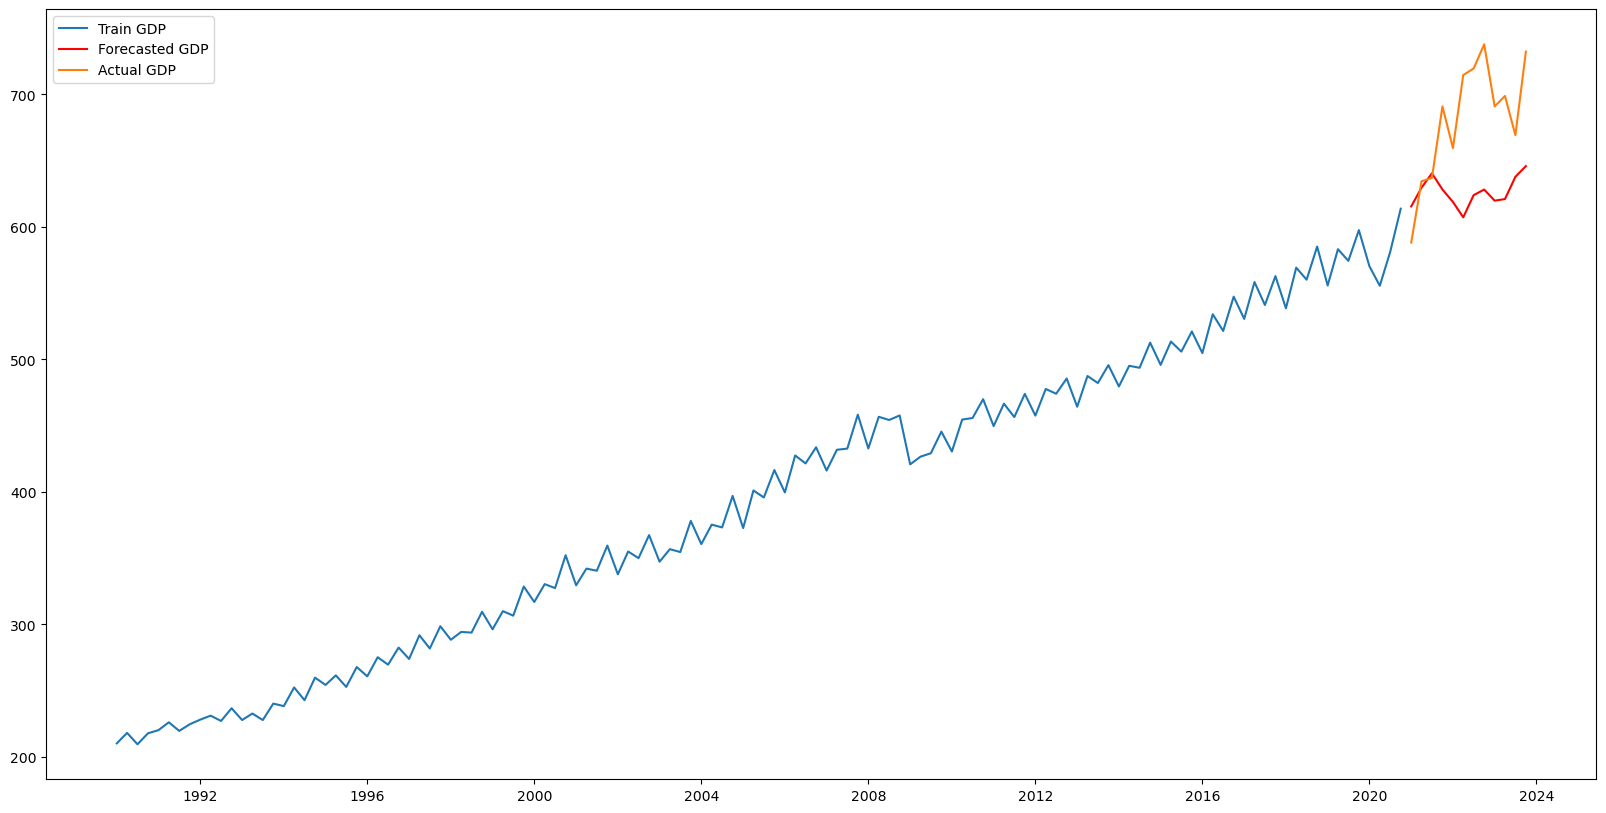

In [9]:
#Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'], gdp_train['Value'], label='Train GDP')
plt.plot(gdp_test['Time'], y_pred_norm, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'], gdp_test['Value'], label='Actual GDP')
plt.legend(loc='upper left')
plt.show()